In [4]:
import os
import sys
from pathlib import Path

mod_path = os.path.join(Path.cwd().parent.parent)
if mod_path not in sys.path:
    sys.path.append(mod_path)

In [5]:
# !pip install pandas numpy
import pandas as pd
# import numpy as np

In [6]:
import pandas as pd
# import numpy as np

# !pip install sklearn
import xgboost as xgb
import collections
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
from collections import Counter

from src.utils import *

In [8]:
train = pd.read_csv("../../data/raw/Train.csv", sep=",")
metadata = pd.read_csv("../../data/raw/metadata.csv", sep=",")
test = pd.read_csv("../../data/raw/Test.csv", sep=",")

/home/nikhil/.local/share/virtualenvs/zindi_paygo-1-T8XSNTNt/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Datasets Join

In [9]:
train_merged = metadata.merge(train, how="right", on="ID")
test_merged = metadata.merge(test, how='right', on='ID')

In [11]:
train_merged.head()

,ID,RegistrationDate,Deposit,UpsellDate,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,...,FirstPaymentDate,LastPaymentDate,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6
0,ID_MR53LEX,2018-04-23 12:28:05,2500,NaN,0.0,FINANCED,DAILY,55,3,Male,...,2018-04-23 12:28:05,2021-05-26 17:14:45,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0
1,ID_3D7NQUH,2018-04-17 10:27:35,2500,NaN,0.0,FINANCED,DAILY,55,3,Male,...,2018-04-17 10:27:35,2021-05-26 16:54:53,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0
2,ID_0IWQNPI,2020-02-18 14:23:44,2400,NaN,0.0,FINANCED,DAILY,50,3,Male,...,2020-02-18 14:23:48,2021-01-25 18:46:20,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0
3,ID_IY8SYB9,2017-09-14 11:07:40,2000,NaN,0.0,FINANCED,DAILY,40,7,Female,...,2017-09-14 11:07:32,2018-12-20 16:50:39,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0
4,ID_9XHL7VZ,2017-09-06 06:50:20,2000,NaN,0.0,FINANCED,DAILY,40,7,Male,...,2017-09-06 06:50:16,2021-05-12 14:50:01,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0


### Payment Related features

In [9]:
def feature_construction(df):
    try:
        df["SplitPaymentsHistory"] = df.apply(lambda row: split(row["PaymentsHistory"]), axis=1)
        df["SplitTransactionDates"] = df.apply(lambda row: split(row["TransactionDates"], type_of_value='date'), axis=1)
        df["nb_payments"] = df.apply(lambda row: length_calc(row["SplitPaymentsHistory"]), axis=1)
        df["amount_paid"] = df.apply(lambda row: sum_calc(row["SplitPaymentsHistory"]), axis=1)
        df["percent_amt_paid"] = df["amount_paid"] / train_merged["TotalContractValue"]
        df["mean_amt_paid"] = df.apply(lambda row: mean_calc(row["SplitPaymentsHistory"]), axis=1)
        df["median_amt_paid"] = df.apply(lambda row: median_calc(row["SplitPaymentsHistory"]), axis=1)
        df["max_amt_paid"] = df.apply(lambda row: max_calc(row["SplitPaymentsHistory"]), axis=1)
        df["min_amt_paid"] = df.apply(lambda row: min_calc(row["SplitPaymentsHistory"]), axis=1)
        df["stddev_amt_paid"] = df.apply(lambda row: std_dev_calc(row["SplitPaymentsHistory"]), axis=1)
    except KeyError as e:
        raise Exception("Column Missing")
        
    return df

train_merged = feature_construction(train_merged)
test_merged = feature_construction(test_merged)

### Number of Missed Payments

In [21]:
from src.utils import convert

def nb_missing_payments(transaction_dates, first_payment_date, last_payment_date):
    payment_dates = set([convert(x) for x in transaction_dates])
    payment_dates_range = set([str(x) for x in pd.period_range(first_payment_date, last_payment_date, freq="M")])
    
    return len(payment_dates_range - payment_dates) - 6

train_merged["nb_skipped_months"] = train_merged.apply(
    lambda row: nb_missing_payments(
        row["SplitTransactionDates"], row.FirstPaymentDate, row.LastPaymentDate
    ), axis=1
)
test_merged["nb_skipped_months"] = train_merged.apply(
    lambda row: nb_missing_payments(
        row["SplitTransactionDates"], row.FirstPaymentDate, row.LastPaymentDate
    ), axis=1
)

ModuleNotFoundError: No module named 'utils'

### Bar Plots for each Month

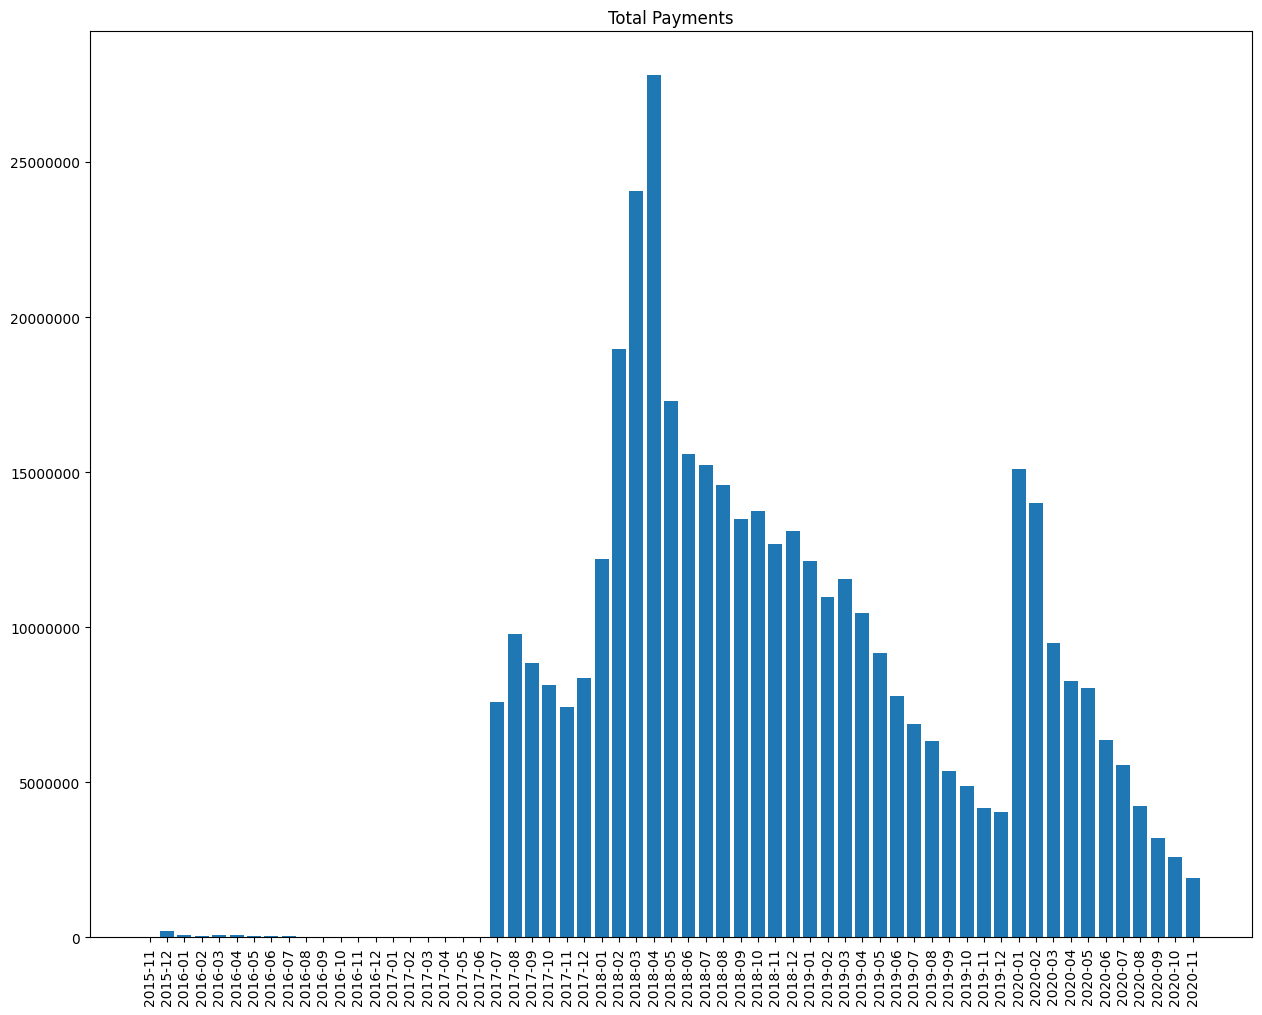

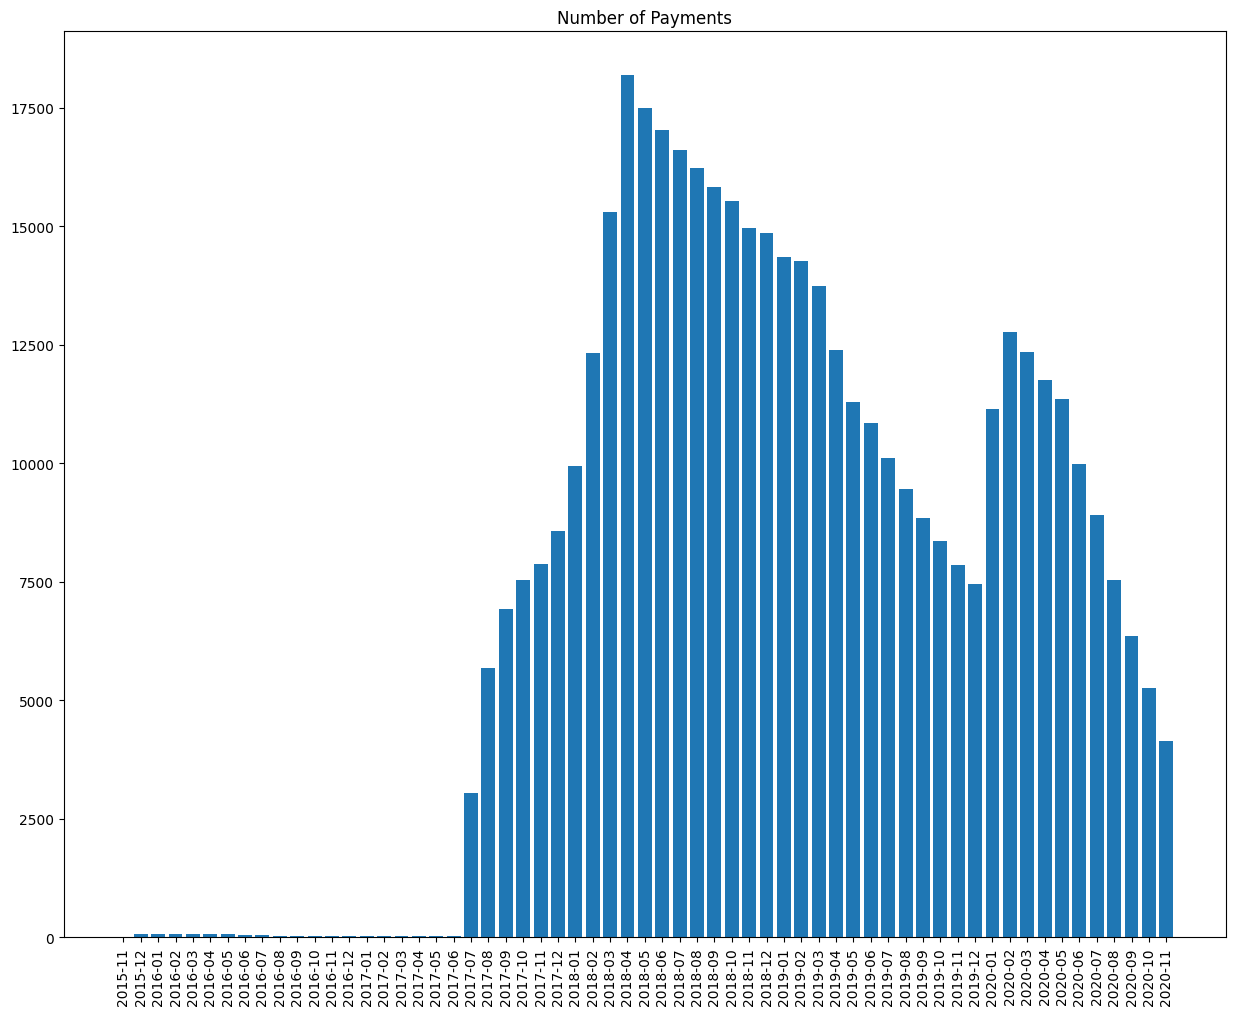

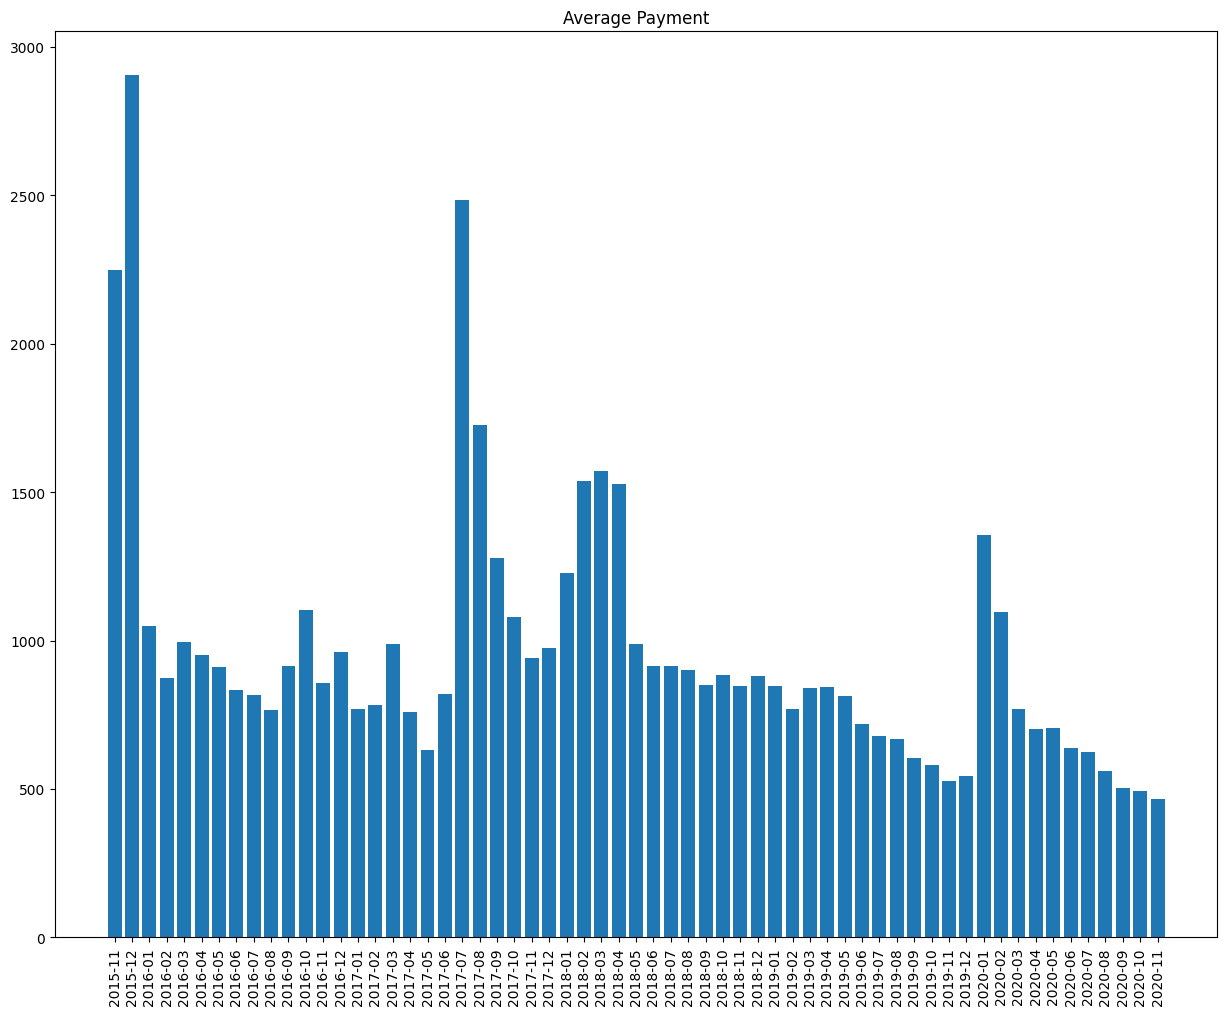

In [22]:
class DateEDA:
    def __init__(self, df):
        self.df = df
    
    @staticmethod
    def find_min_n_max(df):
        min_date = min([convert(x) for x in df.SplitTransactionDates[0]])
        max_date = max([convert(x) for x in df.SplitTransactionDates[0]])
        for i in range(train_merged.shape[0]):
            temp_min = min([convert(x) for x in df.iloc[i]["SplitTransactionDates"]])
            temp_max = max([convert(x) for x in df.iloc[i]["SplitTransactionDates"]])
            
            if temp_min < min_date:
                min_date = temp_min
            if temp_max > max_date:
                max_date = temp_max
        
        return min_date, max_date

    @staticmethod
    def find_stats(df, min_date, max_date):
        
        all_dates = [str(x) for x in pd.period_range(datetime.strptime(min_date, "%Y-%m"), datetime.strptime(max_date, "%Y-%m"), freq="M")]
        date_payments_dict = Counter({date: 0 for date in all_dates})
        date_count_dict = Counter({date: 0 for date in all_dates})
        for i in range(train_merged.shape[0]):
            # Calculates the payments made in each month
            payments_dict = {
                convert(date): float(payment)
                for date, payment in zip(
                    df.iloc[i]["SplitTransactionDates"],
                    df.iloc[i]["SplitPaymentsHistory"]
                )
            }

            # Calculates the number of payments made in each month
            count_dict = {
                convert(date): 1 for date in df.iloc[i]["SplitTransactionDates"]
            }

            date_payments_dict = Counter(payments_dict) + date_payments_dict
            date_count_dict = Counter(count_dict) + date_count_dict

        return dict(date_payments_dict), dict(date_count_dict)
    
    @staticmethod
    def calculate_avg_payments(dict1, dict2):
        return {k: round(dict1[k]/dict2[k], 2) for k in dict1}
    
    @staticmethod
    def plot(target_dict, title=""):
        target_dict = collections.OrderedDict(sorted(target_dict.items()))
        figure(figsize=(15, 12), dpi=100)
        names = list(target_dict.keys())
        values = list(target_dict.values())
        plt.ticklabel_format(style='plain')
        plt.title(title)
        plt.bar(range(len(target_dict)), values, tick_label=names)
        plt.xticks(rotation=90)
        plt.show()

    def execute(self):
        min_date, max_date = self.find_min_n_max(self.df)
        payments_dict, count_dict = self.find_stats(self.df, min_date, max_date)
        avg_payments_dict = self.calculate_avg_payments(payments_dict, count_dict)
        
        self.plot(payments_dict, "Total Payments")
        self.plot(count_dict, "Number of Payments")
        self.plot(avg_payments_dict, "Average Payment")

DateEDA(train_merged).execute()

### Back Payment Features

In [23]:
# Add Back Payment Features


def add_back_feature(df, n=1):
    df[f"b{n}"] = df.apply(lambda row: back_feature(row["SplitPaymentsHistory"], n), axis=1)
    return df

train_merged = add_back_feature(train_merged, 1)
train_merged = add_back_feature(train_merged, 2)
train_merged = add_back_feature(train_merged, 3)
train_merged = add_back_feature(train_merged, 4)
train_merged = add_back_feature(train_merged, 5)

test_merged = add_back_feature(test_merged, 1)
test_merged = add_back_feature(test_merged, 2)
test_merged = add_back_feature(test_merged, 3)
test_merged = add_back_feature(test_merged, 4)
test_merged = add_back_feature(test_merged, 5)

In [29]:
train_merged.shape

(28007, 44)

### Date Related Features

TODO: 
1. Skipped payments and duration of skipping payments
2. Check for custom seasonality (Weather changes EDA)

### Backward Feature elimination

In [26]:
train_merged["RegistrationDateParsed"] = pd.to_datetime(train_merged["RegistrationDate"], infer_datetime_format=True)
train_merged["ExpectedTermDateParsed"] = pd.to_datetime(train_merged["ExpectedTermDate"], infer_datetime_format=True)
train_merged["FirstPaymentDateParsed"] = pd.to_datetime(train_merged["FirstPaymentDate"], infer_datetime_format=True)
train_merged["LastPaymentDateParsed"] = pd.to_datetime(train_merged["LastPaymentDate"], infer_datetime_format=True)

train_merged["RegistrationDate"] = pd.to_datetime(train_merged["RegistrationDate"], infer_datetime_format=True).dt.date
train_merged["ExpectedTermDate"] = pd.to_datetime(train_merged["ExpectedTermDate"], infer_datetime_format=True).dt.date
train_merged["FirstPaymentDate"] = pd.to_datetime(train_merged["FirstPaymentDate"], infer_datetime_format=True).dt.date
train_merged["LastPaymentDate"] = pd.to_datetime(train_merged["LastPaymentDate"], infer_datetime_format=True).dt.date

In [ ]:
train_merged["LastFirstDuration"] = (train_merged.LastPaymentDate - train_merged.FirstPaymentDate).astype("timedelta64[M]")
train_merged["ExpectedFirstDuration"] = (train_merged.ExpectedTermDate - train_merged.FirstPaymentDate).astype("timedelta64[M]")
train_merged["LastRegistrationDuration"] = (train_merged.LastPaymentDate - train_merged.RegistrationDate).astype("timedelta64[M]")

In [ ]:
# Months
train_merged["FirstPaymentMonth"] = train_merged["FirstPaymentDateParsed"].dt.month
train_merged["LastPaymentMonth"] = train_merged["LastPaymentDateParsed"].dt.month
train_merged["RegistrationMonth"] = train_merged["RegistrationDateParsed"].dt.month

# # Sine
# train_merged["FirstPaymentMonthSin"] = np.sin((train_merged.FirstPaymentMonth-1)*(2.*np.pi/12))
# train_merged["LastPaymentMonthSin"] = np.sin((train_merged.LastPaymentMonth-1)*(2.*np.pi/12))
# train_merged["RegistrationMonthSin"] = np.sin((train_merged.RegistrationMonth-1)*(2.*np.pi/12))

# # Cos
# train_merged["FirstPaymentMonthCos"] = np.cos((train_merged.FirstPaymentMonth-1)*(2.*np.pi/12))
# train_merged["LastPaymentMonthCos"] = np.cos((train_merged.LastPaymentMonth-1)*(2.*np.pi/12))
# train_merged["RegistrationMonthCos"] = np.cos((train_merged.RegistrationMonth-1)*(2.*np.pi/12))

In [28]:
train_merged.drop(["RegistrationDateParsed", "ExpectedTermDateParsed", "FirstPaymentDateParsed", "LastPaymentDateParsed"], axis=1, inplace=True)

### We can ignore UpSell since it represents only 2.7% of the rows

In [30]:
train_merged.UpsellDate.count() / train_merged.shape[0] * 100

2.6493376655836043

In [31]:
train_merged.nb_payments.describe()

count    28007.000000
mean        16.262363
std          9.248264
min          5.000000
25%          8.000000
50%         14.000000
75%         23.000000
max         52.000000
Name: nb_payments, dtype: float64

In [32]:
train_merged.columns

Index(['ID', 'RegistrationDate', 'Deposit', 'UpsellDate', 'AccessoryRate',
       'PaymentMethod', 'rateTypeEntity', 'RatePerUnit', 'DaysOnDeposit',
       'MainApplicantGender', 'Age', 'Region', 'Town', 'Occupation',
       'SupplierName', 'Term', 'TotalContractValue', 'ExpectedTermDate',
       'FirstPaymentDate', 'LastPaymentDate', 'TransactionDates',
       'PaymentsHistory', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6',
       'SplitPaymentsHistory', 'SplitTransactionDates', 'nb_payments',
       'amount_paid', 'percent_amt_paid', 'mean_amt_paid', 'median_amt_paid',
       'max_amt_paid', 'min_amt_paid', 'stddev_amt_paid', 'nb_skipped_months',
       'b1', 'b2', 'b3', 'b4', 'b5'],
      dtype='object')

### Drop irrelevant columns

In [34]:
def drop_cols(df):
    df.drop(
        [
#           "ID",
            "UpsellDate",
            "PaymentMethod",
            "TransactionDates",
            "PaymentsHistory",
            "SupplierName",
            "Town",
            "RegistrationDateParsed",
            "ExpectedTermDateParsed",
            "FirstPaymentDateParsed",
            "LastPaymentDateParsed"
        ],
        inplace=True,
        axis=1
    )
drop_cols(train_merged)
drop_cols(test_merged)

In [36]:
train_merged.shape

(28007, 34)

### Feature Encoding

In [ ]:
# OHE

def encode_and_bind(df, feature_name):
    dummies = pd.get_dummies(df[[feature_name]])
    res = pd.concat([df, dummies], axis=1)
    res = res.drop([feature_name], axis=1)
    return(res)

for feature in ["MainApplicantGender", "Region", "Occupation", "rateTypeEntity"]:
    train_merged = encode_and_bind(train_merged, feature)

In [ ]:
train_merged.head()

In [ ]:
train_merged.drop(["RegistrationDate", "ExpectedTermDate", "FirstPaymentDate", "LastPaymentDate", "SplitPaymentsHistory", "SplitTransactionDates", "m2", "m3", "m4", "m5", "m6"], inplace=True, axis=1)


### Data Leakage here. Will be handled later.

In [ ]:
# train_merged.Age.plot()

In [ ]:
train_merged.Age = train_merged.Age.fillna(train_merged.Age.mean())

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

np.random.seed(0)
def predict_model(train_array, target):
    model = xgb.XGBRegressor(use_label_encoder=False,
                             verbosity=0,
                             objective="reg:squarederror",
                             reg_lambda=0,
                             reg_alpha=50)
    
    X_train, X_test, y_train, y_test = train_test_split(train_array, target, test_size=0.20)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    feature_importance = model.feature_importances_
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = pow(mse, 0.5)
    
    print("---------TEST---------")
    print("Predictions")
    print(y_pred)
    print("RMSE:", rmse)
    
    y_pred = model.predict(X_train)
    feature_importance = model.feature_importances_
    mape = mean_absolute_percentage_error(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    rmse = pow(mse, 0.5)
    
    print("---------TRAIN--------")
    print(y_pred)
    print("RMSE:", rmse)
    
    return y_pred, mape, mse, feature_importance, rmse

predict_model(train_merged.drop(["m1"], axis=1), train_merged["m1"])

### Saving the data to data/train.csv

Features created till cell 6 (and cell 9) are selected

In [37]:
train_merged.drop(columns=['SplitTransactionDates'], inplace=True)
test_merged.drop(columns=['SplitTransactionDates'], inplace=True)

In [38]:
train_merged.shape

(28007, 33)

In [39]:
train_merged.to_csv('../../data/processed/train1.csv')
test_merged.to_csv('../../data/processed/test1.csv')

### Outlier Handling
### Advance Modelling
### EDA for adding time features
### Scaling & Normalization